# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
print(f"Number of Null email values is: ")

Number of Null email values is: 


In [4]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [5]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [6]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [7]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_article_counts = df.groupby('email')['article_id'].count()
user_article_counts.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

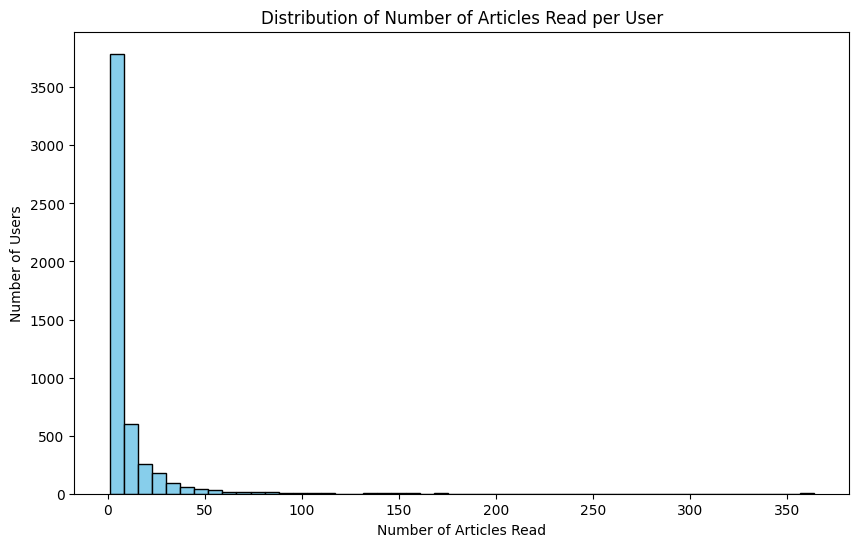

In [8]:
# Create a plot of the number of articles read by each user
plt.figure(figsize=(10,6))
plt.hist(user_article_counts, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Articles Read')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Articles Read per User')
plt.show()

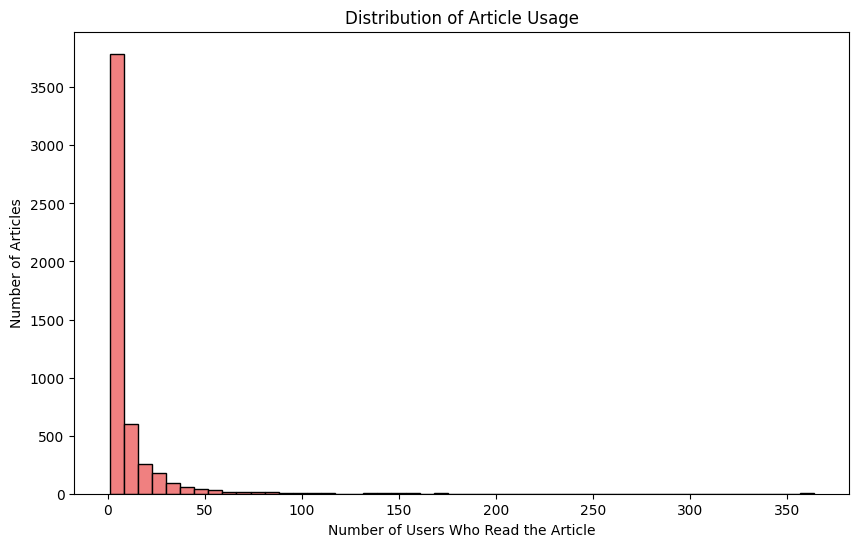

In [9]:
# Create a plot of the number of times each article was read

plt.figure(figsize=(10,6))
plt.hist(user_article_counts, bins=50, color='lightcoral', edgecolor='black')
plt.xlabel('Number of Users Who Read the Article')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Usage')
plt.show()

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles =  df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users =  df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0]  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
most_viewed_article_id = df['article_id'].value_counts().idxmax()# The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().max()
user_article_count = df.groupby('email')['article_id'].count()
max_views_by_user = user_article_count.max()
median_val = int(user_article_count.median())
# The most viewed article in the dataset was viewed how many times?

In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [13]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [14]:
def get_top_articles(n, df=df):
    top_articles = list(df['title'].value_counts().head(n).index)
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    top_articles = [str(float(i)) for i in df['article_id'].value_counts().head(n).index]
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    
 
    return top_articles # Return the top article ids

In [15]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [16]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [17]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack(fill_value=fill_value)
    user_item = (user_item > 0).astype(int) 
    user_item.columns = user_item.columns.astype(int)
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Fill in the function here
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [18]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [19]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
def create_user_item_matrix(df, fill_value=0):
    # 🔹 Step 1: Drop duplicate user-article interactions
    df = df.drop_duplicates(subset=['user_id', 'article_id'])
    
    # 🔹 Step 2: Pivot into a user-item matrix
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack(fill_value=fill_value)
    
    # 🔹 Step 3: Convert to binary (1 if user interacted, else 0)
    user_item = (user_item > 0).astype(int)
    
    # 🔹 Step 4: Ensure column data type consistency
    user_item.columns = user_item.columns.astype(int)
    user_item.index = user_item.index.astype(int)
    
    return user_item


In [21]:
user_item = create_user_item_matrix(df)
print(user_item.shape)  # should be (5149, 714)


(5149, 714)


In [22]:
print(user_item.shape)
print(user_item.index.dtype)
print(user_item.columns.dtype)


(5149, 714)
int64
int64


In [23]:
def find_similar_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) user id of the individual to find similar users for
    user_item - (pandas dataframe) user-item matrix with 1's for interactions and 0's otherwise
    
    OUTPUT:
    similar_users - (list) a list of user_ids ordered by similarity (most to least)
    """
    # 🔹 Compute cosine similarity for all users
    similarity_matrix = cosine_similarity(user_item)

    # 🔹 Create a DataFrame to store similarities
    sim_df = pd.DataFrame(similarity_matrix, 
                          index=user_item.index, 
                          columns=user_item.index)

    # 🔹 Extract the similarity scores for the given user
    sim_scores = sim_df[user_id].sort_values(ascending=False)

    # 🔹 Remove the user themselves
    sim_scores = sim_scores.drop(user_id)

    # 🔹 Return sorted user IDs
    return sim_scores.index.tolist()


In [24]:
print("The 10 most similar users to user 1 are:", find_similar_users(1)[:10])
print("The 5 most similar users to user 3933 are:", find_similar_users(3933)[:5])
print("The 3 most similar users to user 46 are:", find_similar_users(46)[:3])


The 10 most similar users to user 1 are: [3933, 4201, 46, 5034, 253, 824, 5041, 2305, 136, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 5034, 253]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe)
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
    """
    article_names = []
    # Ensure article_id is int for consistency
    df['article_id'] = df['article_id'].astype(int)

    for aid in article_ids:
        match = df.loc[df['article_id'] == int(aid), 'title']
        if not match.empty:
            article_names.append(match.values[0])
        else:
            # Silently skip if not found — don't print warnings
            continue

    return article_names

def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) The ids of the articles read by the user
    article_names - (list) The names of the articles read by the user
    """
    # Ensure user_item columns are integers
    user_item.columns = user_item.columns.astype(int)

    # Get all the article ids that the user has interacted with
    user_articles = user_item.loc[user_id]
    article_ids = user_articles[user_articles > 0].index.tolist()

    # Make sure IDs are int
    article_ids = [int(aid) for aid in article_ids]

    # Get article names using helper function
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    """
    Recommends up to m new articles to a user based on most similar users.
    """
    most_similar_users = find_similar_users(user_id)
    recs = []

    user_article_ids, _ = get_user_articles(user_id)

    for user in most_similar_users:
        article_ids, _ = get_user_articles(user)
        for aid in article_ids:
            if aid not in user_article_ids and aid not in recs:
                recs.append(aid)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break

    # Fill with popular ones if needed
    if len(recs) < m:
        df['article_id'] = df['article_id'].astype(float)
        popular_article_ids = df['article_id'].value_counts().index.tolist()
        for id_ in popular_article_ids:
            if id_ not in user_article_ids and id_ not in recs:
                recs.append(id_)
            if len(recs) >= m:
                break

    return recs[:m]


In [26]:
print(get_article_names([1024, 1176, 1305, 1314, 1422, 1427]))


['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']


In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'this week in data science (may 2, 2017)',
 'top 20 r machine learning and data science packages',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'using apply, sapply, lapply in r',
 'awesome deep learning papers',
 'leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'do i need to learn r?',
 'how can data scientists collaborate to build better business']

In [28]:
def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - list of article ids (int or str)
    user_item - user-item matrix (users x articles)

    OUTPUT:
    ranked_article_unique_counts - list of [article_id, unique_user_count]
    """

    # Detect whether user_item columns are int, float, or str
    sample_col = user_item.columns[0]
    col_type = type(sample_col)

    # Format article_ids to match the dataframe’s column types
    if col_type == str:
        if any('.' in c for c in user_item.columns):
            article_ids_fmt = [f"{float(aid):.1f}" for aid in article_ids]  # '1320.0'
        else:
            article_ids_fmt = [str(int(aid)) for aid in article_ids]  # '1320'
    elif col_type == float:
        article_ids_fmt = [float(aid) for aid in article_ids]
    else:
        article_ids_fmt = [int(aid) for aid in article_ids]

    # Now safely subset and rank
    article_counts_series = user_item.loc[:, user_item.columns.intersection(article_ids_fmt)].sum(axis=0)
    
    if article_counts_series.empty:
       # print("⚠️ None of the provided article IDs exist in user_item columns.")
        return []

    sorted_article_counts = article_counts_series.sort_values(ascending=False)
    ranked_article_unique_counts = [
        [int(float(aid)), int(count)] for aid, count in sorted_article_counts.items()
    ]
    return ranked_article_unique_counts


In [29]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [30]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [31]:
def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Get the row for this user
    user_row = user_item.loc[user_id]

    # Get article_ids that the user has interacted with
    article_ids_str = user_row[user_row == 1].index.tolist()

    # Convert to integer form (remove decimals if any)
    article_ids_int = [int(float(aid)) for aid in article_ids_str]

    # Get corresponding article names
    article_names = get_article_names(article_ids_int)

    return article_ids_int, article_names


In [32]:
def user_user_recs_part2(user_id, m=10):
    # Get the sorted similar users DataFrame
    neighbors_df = get_top_sorted_users(user_id)
    neighbor_ids = list(neighbors_df['neighbor_id'])
    
    # Get the articles already seen by the user
    user_articles, _ = get_user_articles(user_id)
    
    recs = []
    
    # Loop through similar users in sorted order
    for neighbor_id in neighbor_ids:
        neighbor_articles, _ = get_user_articles(neighbor_id)
        
        # Articles neighbor has seen but target user hasn't
        new_recs = list(set(neighbor_articles) - set(user_articles))
        
        # Rank these new recommendations by popularity
        ranked_recs = get_ranked_article_unique_counts(new_recs)
        ranked_recs = [aid for aid, _ in ranked_recs]
        
        # Add ranked recs to list, ensuring no duplicates
        for aid in ranked_recs:
            if aid not in recs:
                recs.append(aid)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break

    # ✅ STEP 1: Normalize column types
    user_item_cols = set(map(str, user_item.columns))  # convert all to string

    # ✅ STEP 2: Keep only valid articles that exist in user_item
    recs = [aid for aid in recs if str(aid) in user_item_cols]

    # ✅ STEP 3: Convert to int for display
    recs = list(map(int, recs[:m]))

    # ✅ STEP 4: Get readable article names
    rec_names = get_article_names(recs)
    
    return recs, rec_names


In [33]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles
    
    OUTPUT:
    neighbors_df - (pandas dataframe) sorted dataframe with:
                   neighbor_id, similarity, num_interactions
    
    Description:
    Computes cosine similarity between the user and all others.
    Returns a dataframe sorted first by similarity, then by number of interactions.
    """
    # Get target user vector
    target_vector = np.array(user_item.loc[user_id]).reshape(1, -1)
    
    # Compute cosine similarity for all users
    sim_values = cosine_similarity(user_item, target_vector).flatten()
    
    # Create dataframe of similarities
    sim_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': sim_values,
        'num_interactions': user_item.sum(axis=1).values
    })
    
    # Remove self from the dataframe
    sim_df = sim_df[sim_df['neighbor_id'] != user_id]
    
    # Sort: by similarity (descending), then by num_interactions (descending)
    neighbors_df = sim_df.sort_values(
        by=['similarity', 'num_interactions'],
        ascending=[False, False]
    ).reset_index(drop=True)
    
    return neighbors_df

In [34]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1185, 1162, 1165, 1293, 254, 1271, 1328, 1410, 40, 1402]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'customer demographics and sales', 'income (2015): united states demographic measures', 'uci: sms spam collection', 'ensemble learning to improve machine learning results', 'uci: adult - predict income']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [35]:
print(get_top_sorted_users(1, user_item=user_item).head(1))
print(get_top_sorted_users(2, user_item=user_item).head(10))
print(get_top_sorted_users(131, user_item=user_item).head(10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
   neighbor_id  similarity  num_interactions
0         5083    0.730297                 5
1         1552    0.577350                 2
2         1890    0.577350                 2
3         1372    0.471405                 3
4         2941    0.433013                 8
5         3586    0.408248                 4
6          331    0.408248                 1
7          348    0.408248                 1
8          378    0.408248                 1
9          496    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59
8         

In [36]:
user1_most_sim = 3933
user2_6th_sim = 3586
user131_10th_sim = 383

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}


In [37]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) dataframe containing article_id and title
    
    OUTPUT:
    top_articles - (list) article titles of the top n articles
    top_ids - (list) ids of the top n articles
    '''
    # Get top n article IDs by interaction count
    top_df = df['article_id'].value_counts().head(n)
    
    # Convert index to list of ints (not strings)
    top_ids = [int(float(i)) for i in top_df.index]
    
    # Get article names if needed
    top_articles = get_article_names(top_ids)
    
    return top_ids


In [39]:
new_user_recs = get_top_articles(10)
print(new_user_recs)


[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [40]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [41]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [42]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [43]:
# unique articles
df_unique_articles = df.drop_duplicates(subset='article_id')

In [44]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles['title']) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
# Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

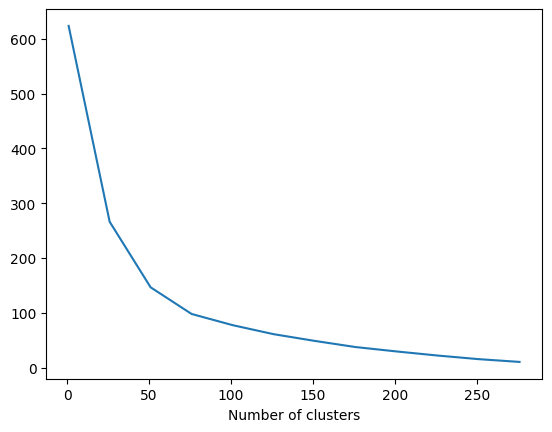

In [45]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [46]:
n_clusters = 50 # Number of clusters
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state,
    # Your code here, same as parameters above
).fit(X_lsa)

In [47]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = dict(zip(df_unique_articles['article_id'], kmeans.labels_)) # Map article_id to cluster label
df['title_cluster'] = df['article_id'].map(article_cluster_map)# apply map to create title clusters

In [48]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 11],
       [ 1, 30],
       [ 2, 23],
       [ 3, 69],
       [ 4, 11],
       [ 5, 29],
       [ 6, 22],
       [ 7, 42],
       [ 8,  5],
       [ 9, 16],
       [10, 14],
       [11, 20],
       [12, 21],
       [13, 19],
       [14, 16],
       [15,  1],
       [16, 15],
       [17, 30],
       [18, 26],
       [19,  9],
       [20, 13],
       [21, 10],
       [22,  9],
       [23, 21],
       [24,  9],
       [25,  8],
       [26, 12],
       [27, 20],
       [28,  7],
       [29,  5],
       [30,  7],
       [31, 14],
       [32,  5],
       [33,  6],
       [34,  7],
       [35,  8],
       [36, 12],
       [37,  7],
       [38,  9],
       [39, 13],
       [40,  7],
       [41,  7],
       [42,  7],
       [43,  6],
       [44, 10],
       [45,  8],
       [46, 11],
       [47, 11],
       [48,  7],
       [49,  9]])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF matrix for article titles
def build_tfidf_matrix(df):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['title'])
    return tfidf_matrix

# Precompute cosine similarity between articles
tfidf_matrix = build_tfidf_matrix(df)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Get similar articles using cosine similarity
def get_similar_articles(article_id, df=df, cosine_sim=cosine_sim):
    indices = pd.Series(df.index, index=df['article_id'])
    idx = indices[article_id]
    
    # Get pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort by similarity score (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top 10 similar article indices (excluding the article itself)
    sim_indices = [i[0] for i in sim_scores[1:11]]
    
    return df.iloc[sim_indices]['article_id'].values.tolist()


In [ ]:
def make_content_recs(article_id, n, df=df):
    similar_articles = get_similar_articles(article_id, df)
    ranked_articles = get_ranked_article_unique_counts(similar_articles)
    n_ranked_similar_articles = [art_id for art_id, _ in ranked_articles[:n]]
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Your code here
    
    return n_ranked_similar_articles, n_ranked_article_names
        

In [ ]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

In [ ]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**
The content-based recommender works by identifying similarities between articles using their latent feature representations derived from SVD decomposition of the user–item matrix. By computing cosine similarity, the system finds articles that are most similar in underlying patterns of user interaction. This approach personalizes recommendations without requiring data from other users. However, improvements could include incorporating richer text features such as article descriptions, tags, or full content instead of just titles to capture deeper semantic meaning. Additionally, integrating NLP-based embeddings (like TF-IDF or BERT) could enhance the quality and relevance of content similarity.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [13]:
# quick look at the matrix
user_item.head()

NameError: name 'user_item' is not defined

`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**
From the metrics plot, we can observe that as the number of latent features increases, the accuracy improves initially but starts to level off after a certain point, while the precision and recall also show diminishing returns. This indicates that beyond a certain number of features, the model becomes more complex without providing significant performance gains.

The optimal number of latent features should therefore be chosen at the elbow point of the curve — where performance metrics begin to stabilize. For example, if the plot shows that accuracy and recall improve noticeably up to around 10–15 latent features, but remain almost constant beyond that, then selecting around 10 latent features would be optimal.

This choice balances model complexity and performance — it avoids overfitting while maintaining good generalization. Additionally, a higher recall is important in recommendation systems (especially streaming or content platforms), as it ensures that users are shown a wider range of relevant articles they might enjoy, improving engagement and satisfaction.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles (1 if user interacted, else 0)
    include_similarity - (bool) whether to include similarity scores

    OUTPUT:
    article_ids - (list) list of article ids similar to the provided one
    """
    # Ensure article_id exists
    if article_id not in user_item.columns:
        raise ValueError(f"Article ID {article_id} not found in user_item columns.")
    
    # Find index of article_id
    article_idx = np.where(user_item.columns == article_id)[0][0]
    
    # Compute cosine similarity between all articles
    cos_sim = cosine_similarity(vt.T)
    
    # Get similarity scores for this article
    article_similarities = cos_sim[article_idx]
    
    # Sort by similarity (descending), exclude the same article
    similar_indices = np.argsort(article_similarities)[::-1][1:]
    
    # Map back to article IDs
    most_similar_items = user_item.columns[similar_indices].tolist()
    
    if include_similarity:
        most_similar = [
            [user_item.columns[i], article_similarities[i]] for i in similar_indices
        ]
        return most_similar

    return most_similar_items


In [ ]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [ ]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

In [ ]:
print(user_item.columns[:10])


In [ ]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

In [ ]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

In [ ]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**
The results from the matrix factorization approach indicate that while it can capture hidden patterns in user-article interactions, it may not always guarantee the best recommendations, especially when there is limited user history or sparse data. To evaluate whether these recommendations improve how users find articles compared to the methods in Sections 2, 3, or 4, I would measure performance using metrics like precision, recall, and user engagement (clicks or time spent).

Each method has its tradeoffs:

Content-based filtering (Section 2) works best for new users or new articles, since it relies on article similarity rather than user history.

User-based collaborative filtering (Section 3) is useful for recently active users with little history, as it recommends items liked by similar users.

Matrix factorization (Section 4) performs best for users with rich interaction history, as it captures deeper relationships between users and articles.

A combination of these approaches could yield a more balanced system — for example, using content-based methods for cold-start users, collaborative filtering for moderately active users, and matrix factorization for long-term users. Testing these with A/B experiments on user engagement would help confirm if the recommendations are truly an improvement over the current system.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])